In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import os.path as op
import seaborn as sns
from nilearn import surface
import pingouin
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvetica'


bids_folder = '/data2/risk_precision/ds-numrisk/'

In [9]:
neural_results = pd.read_csv(op.join(bids_folder, 'derivatives', 'summary_data', 'neural_results_aug2021.tsv'), sep='\t')
neural_results = neural_results.set_index(['type', 'subject', 'mask'])
neural_results['log(neural precision)'] = np.log(neural_results['neural precision'])


behav = pd.read_csv(op.join('/data2/risk_precision/', 'riskPrecision_data.csv')).set_index('subject')
behav.index = behav.index.astype(int)

In [10]:
from pandas import IndexSlice as ix_

In [11]:
formiguel = neural_results.loc[ix_['trialwise', :, ['NPC', 'NPC_L', 'NPC_R']], :].unstack('mask')[['neural precision', 'slope']]


formiguel.to_csv('/data2/risk_precision/ds-numrisk/derivatives/summary_data/miguel_aug2021.csv')

In [12]:
df = behav.join(neural_results)

In [13]:
df['slope/intercept'] = df['slope'] / df['intercept']
df['slope2/intercept2'] = df['slope2'] / df['intercept2']
df['log(sd)'] = np.log(df['sd'])
df['log(mutual information)'] = np.log(df['mutual information'])

/Users/gdehol/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


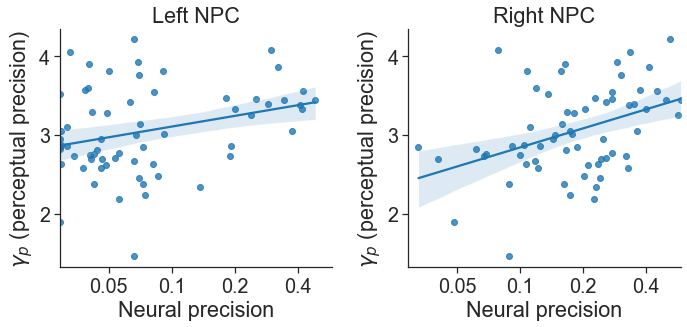

In [14]:
# sns.set(font_scale = 4., style='ticks', palette=None)
sns.set_theme(font_scale = 1.8, style='ticks', palette=None)


tmp = df.query('(mask in ["NPC_L", "NPC_R"]) & (type == "trialwise")').reset_index()

tmp['mask'] = tmp['mask'].map({'NPC_L':'Left NPC', 'NPC_R':'Right NPC'})

fac = sns.lmplot('log(neural precision)', 'mag_prec', col='mask', hue='mask', 
                 palette=sns.color_palette()[:1],
                 sharey=False,
                 aspect=1.,
                 data=tmp)

fac.set(ylabel='$\gamma_p$ (perceptual precision)', xlabel='Neural precision')
# fac.axes.ravel()[0].set_xticklabels('Neural precision')
plt.xticks(np.log([.05, .1, .2, .4]), [.05, .1, .2, .4])


plt.tight_layout()

fac.set_titles('{col_name}')

plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/figures/decoding/behavioral_neural_precision.pdf',
           transparent=True)

In [15]:
df = df.xs('NPC_R', 0, 'mask').xs('trialwise', 0, 'type')

/Users/gdehol/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='riskprec_coin', ylabel='Density'>

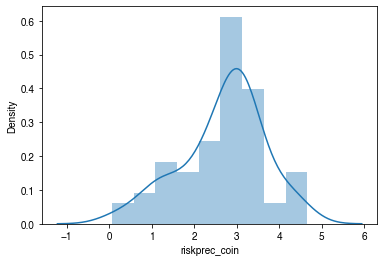

In [132]:
sns.distplot(df['riskprec_coin'])

In [159]:
df['Perceptual precision'] = df['mag_prec']

df['Risk precision (non-symbolic)'] = df['riskprec_coin']
df['Risk precision (symbolic)'] = df['riskprec_sym']

df['log(Risk precision (non-symbolic))'] = np.log(df['riskprec_coin'])
df['log(Risk precision (symbolic))'] = np.log(df['riskprec_sym'])

df['RNP (non-symbolic)'] = df['rnp_coin']
df['RNP (symbolic)'] = df['rnp_sym']

In [160]:


neural_regressors = ['log(neural precision)', 'slope']

behavioral_regressors = ['Perceptual precision', 'Risk precision (non-symbolic)', 
                        'Risk precision (symbolic)', 'RNP (non-symbolic)',
                        'RNP (symbolic)',
                        'log(Risk precision (non-symbolic))',
                        'log(Risk precision (symbolic))']

In [161]:
from itertools import product

# Pearson

In [175]:
rs = []
keys = []

for br, nr in product(behavioral_regressors, neural_regressors):
    rs.append(pingouin.corr(df[br], df[nr], method='pearson').iloc[0])
    keys.append((br, nr))
    
rs = pd.concat(rs, keys=keys, names=['behavior', 'neural'])
rs = rs.unstack()[['r', 'p-val', 'BF10']].rename(columns={'p-val': 'p-val (two-sided)'})
rs.columns.name = 'parameter'
rs['p-val (one-sided)'] = rs['p-val (two-sided)'] / 2.
rs = rs.drop('p-val (two-sided)', 1)
rs = rs.stack().unstack(['neural', 'parameter'])

rs.astype(float).round(3)

<ipython-input-175-3d32d2bc2a46>:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  rs = rs.drop('p-val (two-sided)', 1)


neural                             Neural diminishing sensitivity         \
parameter                                                       r   BF10   
behavior                                                                   
Perceptual precision                                       -0.059  0.174   
RNP (non-symbolic)                                         -0.268  1.464   
RNP (symbolic)                                             -0.140  0.283   
Risk precision (non-symbolic)                              -0.213  0.633   
Risk precision (symbolic)                                  -0.180  0.420   
log(Risk precision (non-symbolic))                         -0.354  8.772   
log(Risk precision (symbolic))                             -0.295  2.423   

neural                                               log(neural precision)  \
parameter                          p-val (one-sided)                     r   
behavior                                                                     
Perceptual precision                           0.320                 0.404   
RNP (non-symbolic)                             0.016                 0.258   
RNP (symbolic)                                 0.135                 0.085   
Risk precision (non-symbolic)                  0.045                 0.122   
Risk precision (symbolic)                      0.077                 0.118   
log(Risk precision (non-symbolic))             0.002                 0.190   
log(Risk precision (symbolic))                 0.009                 0.151   

neural                                                        
parameter                             BF10 p-val (one-sided)  
behavior                                                      
Perceptual precision                33.236             0.000  
RNP (non-symbolic)                   1.247             0.020  
RNP (symbolic)                       0.194             0.251  
Risk precision (non-symbolic)        0.244             0.169  
Risk precision (symbolic)            0.238             0.177  
log(Risk precision (non-symbolic))   0.469             0.067  
log(Risk precision (symbolic))       0.311             0.117